<a href="https://colab.research.google.com/github/Davz33/tutorials/blob/tensorflow/fashion_mnist_classifier_tf1vstf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Content:
This notebook buils on the work of YUFENG GUO for Google Inc. from 2017 Google Notebooks within the tensorflow Google courses.

The goal is to roll back to the 2017-way of classifying Zalando's fashion MNIST data (Tensorflow v.1), and compare it side-by-side to a 2023-regular workflow with Tensorflow v.2.

Backward Compatibility is aided (but not guaranteed) by employing  *tensorflow.compat.v1.*

### Authors:
*   Davide Vitiello [github.com/Davz33](https://github.com/davz33) | [davide_vitiello@outlook.com](mailto:davide_vitiello@outlook.com)
*   Yufeng Guo [github.com/yufengg](https://github.com/yufengg)
* The Tensorflow Authors Authors (Google Inc., 2017)

### License
The chunks of code running tensorflow v.1 are originally licensed to Google Inc. , under the apache license 2.0 (printed below), and thereof copyright belongs to 2017 Google Inc. , for all indetical lines of code.

Concerning the addition by [Davide Vitiello](https://github.com/davz33) , covering the tensorflow v2.0 chunks, the Apache 2.0 license apply, with full text available at:
> https://opensource.org/licenses/Apache-2.0

#### License Text
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
limitations under the License.

##### Copyright
The rights holder of the respective parts of the code are:
*   Davide Vitiello [github.com/Davz33](https://github.com/davz33) | [davide_vitiello@outlook.com](mailto:davide_vitiello@outlook.com)
*   2017 Google Inc.
under the aforementioned licenses

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
!mkdir utils && cd utils && wget https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/b2617bb6d3ffa2e429640350f613e3291e10b141/utils/mnist_reader.py
from utils import mnist_reader

mkdir: cannot create directory ‘utils’: File exists


In [2]:
#import

#tf1
!mkdir data && cd data && wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz && wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz && wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz && wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

X_train_, y_train_ = mnist_reader.load_mnist('data', kind='train')
X_test_, y_test_ = mnist_reader.load_mnist('data', kind='t10k')
print("fashion_mnist:\n:",
      type(X_train_),"\n",
      type(y_train_),"\n",
      [np.shape(d) for d in [X_train_,y_train_,X_test_,y_test_]])

mkdir: cannot create directory ‘data’: File exists
fashion_mnist:
: <class 'numpy.ndarray'> 
 <class 'numpy.ndarray'> 
 [(60000, 784), (60000,), (10000, 784), (10000,)]


In [3]:
#import

#tf2
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("fashion_mnist:\n:",
      type(x_train),"\n",
      type(y_train),"\n",
      [np.shape(d) for d in [x_train,y_train,x_test,y_test]])
#each image is 28x28.
#images thus need flattening

fashion_mnist:
: <class 'numpy.ndarray'> 
 <class 'numpy.ndarray'> 
 [(60000, 28, 28), (60000,), (10000, 28, 28), (10000,)]


For this classifier, the pixel are the features itself.
The classes are represented by 10 types of clothing items.

In [4]:
#define parameters for model 
N_CLASSES=10,
BATCH_SIZE=32

In [5]:
#tf1 flow:
with tf1.Session() as session:
  input_ = tf1.estimator.inputs.numpy_input_fn(
      x = {'pixels': X_train_/255},
      y = y_train_,
      batch_size=100,
      num_epochs=3,
      shuffle=True)
  
  classifier = tf1.estimator.LinearClassifier(
      feature_columns = [tf1.feature_column.numeric_column("pixels",shape=784)],
      n_classes = N_CLASSES
  )
  classifierwDNN = tf1.estimator.DNNClassifier(
      feature_columns = [tf1.feature_column.numeric_column("pixels",shape=784)],
      n_classes = N_CLASSES,
      hidden_units = [200, 100, 50]
  )

In [6]:
#tf2 flow:
train_nm = tf.cast(x_train,tf.float32)/255
test_nm  = tf.cast(x_test,tf.float32)/255
data_ = tf.data.Dataset.from_tensor_slices(
    (
        train_nm,
        y_train
    )
)
test_ = tf.data.Dataset.from_tensor_slices(
    (
        test_nm,
        y_test
    )
)
bdata = data_.cache().repeat().shuffle(60000).batch(BATCH_SIZE)
beval = test_.cache().batch(BATCH_SIZE)#to match dimensions during model.eval
#it is necessary that your batch size for train and test keep constant
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(100,activation=tf.nn.relu),
        tf.keras.layers.Dense(10,activation = tf.nn.softmax)
    ]
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#
print("tf1:\ndata(via input function):\n",input_,"\nclassifier:\n",classifier,"\ntf2:\ndata:\n",bdata,"\nmodel:\n",model)

tf1:
data(via input function):
 <function numpy_input_fn.<locals>.input_fn at 0x7ff2e14511f0> 
classifier:
tf2:
data:
 <BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))> 
model:


TF2 model workflow


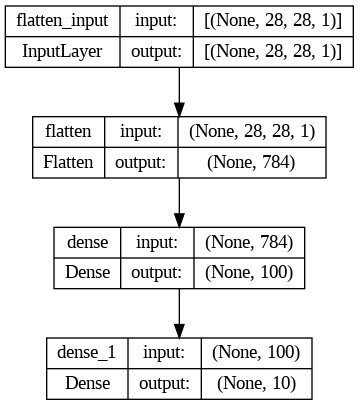

In [7]:
print("TF2 model workflow")
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True,)

In [8]:
#train the model

#tf1:

#classifier.train(input_fn=input_)

#accuracy = classifier.evaluate(input_fn=input_(x_test,y_test),steps=100)['accuracy']
#print('\nAccuracy: {0:f}'.format(accuracy))

In [9]:
#train the model

#tf2:
model.fit(
    bdata,
    epochs=10,
    steps_per_epoch=60000/BATCH_SIZE
)

Epoch 1/10
1875/1875 [==============================] - 18s 7ms/step - loss: 0.4938 - accuracy: 0.8262
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3753 - accuracy: 0.8651
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3385 - accuracy: 0.8760
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3138 - accuracy: 0.8857
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3001 - accuracy: 0.8897
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2848 - accuracy: 0.8957
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2692 - accuracy: 0.9017
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2587 - accuracy: 0.9037
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2505 - accuracy: 0.9062
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss

In [10]:
import math
test_loss, test_accuracy = model.evaluate(beval, steps=math.ceil(10000/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3332 - accuracy: 0.8829
Accuracy on test dataset: 0.8828999996185303


Here's a variable overview to help comprehension:

| Name           | Type               | Shape           | Value                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|----------------|--------------------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BATCH_SIZE     | int                |                 | 32                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| N_CLASSES      | tuple              | 1 item          | (10,)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| X_test_        | ndarray            | (10000, 784)    | array([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| X_train_       | ndarray            | (60000, 784)    | array([[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| bdata          | BatchDataset       |                 | <BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| beval          | BatchDataset       |                 | <BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| classifier     | LinearClassifier   |                 | <tensorflow_estimator.python.estimator.canned.linear.LinearClassifier object at 0x7ff2f483b6d0>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| classifierwDNN | DNNClassifier      |                 | <tensorflow_estimator.python.estimator.canned.dnn.DNNClassifier object at 0x7ff2e14dbee0>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| data_          | TensorSliceDataset |                 | <TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| model          | Sequential         |                 | <keras.engine.sequential.Sequential object at 0x7ff2e023b0d0>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| session        | Session            |                 | <tensorflow.python.client.session.Session object at 0x7ff2f483b2b0>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| test_          | TensorSliceDataset |                 | <TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| test_accuracy  | float              |                 | 0.8829                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| test_loss      | float              |                 | 0.333191931                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| test_nm        | EagerTensor        | (10000, 28, 28) | <tf.Tensor: shape=(10000, 28, 28), dtype=float32, numpy= array([[[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], ..., [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)> |
| train_nm       | EagerTensor        | (60000, 28, 28) | <tf.Tensor: shape=(60000, 28, 28), dtype=float32, numpy= array([[[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], ..., [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]], [[0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.], [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)> |
| x_test         | ndarray            | (10000, 28, 28) | array([[[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], ..., [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)                                                                                                                                                                                                                                                                                     |
| x_train        | ndarray            | (60000, 28, 28) | array([[[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], ..., [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]], [[0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0], [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)                                                                                                                                                                                                                                                                                     |
| y_test         | ndarray            | (10000,)        | array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| y_test_        | ndarray            | (10000,)        | array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| y_train        | ndarray            | (60000,)        | array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| y_train_       | ndarray            | (60000,)        | array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |